<a href="https://colab.research.google.com/github/zen8802/healthinamerica/blob/main/healthinamerica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Trends in America
## by Zen Yoshida


---

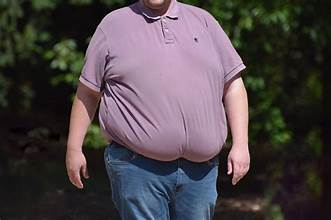


# Abstract

The goal of this project is to investigate obesity and related variables in the United States, aiming to uncover insights for public health awareness in the country. The project will utilize variables such as BMI classifications, and their relationship with factors such as exercise rates and cholesterol trends. Through a meticulous exploration of datasets, the research aims to look into the effectiveness of interventions geared towards promoting healthier lifestyles.

The challenges in this project revolve around the complexity of the factors contributing to obesity and the need for a multidimensional analysis. Exploring the interplay between exercise, cholesterol, and obesity requires careful consideration of diverse datasets, certainly involving demographic information, geographic variations, and socioeconomic factors.

Despite these challenges, my hope is to provide meaningful insight to my reader. The exploration will involve data acquisition from sources such as the Behavioral Risk Factor Surveillance System (BRFSS) and Centers for Disease Control and Prevention (CDC).



# Section I: BRFSS Overweight and Obesity

The Behavioral Risk Factor Surveillance System (BRFSS) is a program conducted by the CDC in the United States. It is a state-based, ongoing, and systematic data collection initiative designed to monitor and track health-related behaviors, chronic health conditions, and use of preventive services among adults in the United States.

The first API we will analyze is BRFSS' Table of Overweight and Obesity (BMI)
Behavioral Risk Factors. BRFSS combined land line and cell phone prevalence data, meaning the data is collected by reaching out to individuals over the phone. This is how they frequently conduct their nationwide surveys.

The API begins in 2011, and continues to present time. There are 27 columns.

The dataset is cleaned in order to select only the relevant columns, 9 in total.
After cleaning for null values, the dataset currently sits at 51415 rows.

**Year:** Year of sampling

**Locationdesc:** State name

**Sample_size:** Total number of people measured in group

**Response:** Underweight, Normal weight, Overweight or Obese

**Break_out:** Categorization variable. Was this sample aggregated by gender, age group, wealth, etc., or without any subgrouping?

**Break_out_category:** Identification for each subgroup

**Data_value:** Prevalence of population falling into specified response, measured in percent.

**Confidence_limit_low:** Lower bound of the confidence interval

**Confidence_limit_high:** Upper bound of the confidence interval

  1) Below is a look at the first 8 rows of the data.


In [ ]:

import requests
import pandas as pd

# CDC API endpoint
api_url = "https://data.cdc.gov/resource/fqb7-mgjf.json"


columns_to_keep = ['year', 'locationdesc', 'sample_size', 'response', 'break_out', 'break_out_category', 'data_value', 'confidence_limit_low', 'confidence_limit_high']  # Replace with your actual column names


dfs = []

batch_size = 1000

# Make requests until all data is retrieved
offset = 0
while True:
    params = {'$offset': offset, '$limit': batch_size}
    response = requests.get(api_url, params=params)
    if not response.json():
        break

    dfs.append(pd.DataFrame(response.json(), columns=columns_to_keep))
    offset += batch_size

df = pd.concat(dfs, ignore_index=True)

# Drop rows with null values in 'data_value'
df = df.dropna(subset=['data_value'])
df['response'] = df['response'].str.lower()
df = df[~df['locationdesc'].str.contains('median')]

# Display the dimensions of the updated DataFrame
print("Dimensions of the DataFrame: ", df.shape)




In [ ]:

print(df.head(8))

   year locationdesc sample_size                       response break_out  \
0  2022      Alabama          69    underweight (bmi 12.0-18.4)   Overall   
1  2022      Alabama        1016  normal weight (bmi 18.5-24.9)   Overall   
2  2022      Alabama        1460     overweight (bmi 25.0-29.9)   Overall   
3  2022      Alabama        1663        obese (bmi 30.0 - 99.8)   Overall   
4  2022      Alabama          24    underweight (bmi 12.0-18.4)      Male   
5  2022      Alabama         384  normal weight (bmi 18.5-24.9)      Male   
6  2022      Alabama         703     overweight (bmi 25.0-29.9)      Male   
7  2022      Alabama         649        obese (bmi 30.0 - 99.8)      Male   

  break_out_category data_value confidence_limit_low confidence_limit_high  
0            Overall        2.0                  1.3                   2.6  
1            Overall       26.1                 24.1                  28.0  
2            Overall       33.7                 31.7                  35.7 

As one can see, each row does not each represent an individual submission, but rather the aggregate points for break_out groups, separated by response. For example, the fifth row has 24 samples for Underweight response in break_out category of Male gendered.  




2) Let us first visualize the obesity epidemic as a whole in the United States. By filtering the dataset for the Overall break_out subgroup, then filtering for the Obese (BMI 30.0-99.8) response, we can get the scope of the data_value for each state.







Lets compare two years, 2012 and 2022, to grasp how obesity has transformed over a decade.

In [ ]:

import geopandas as gpd
import folium
from IPython.display import HTML, display

df_filtered = df[(df['break_out_category'] == 'Overall')
                 & (df['year'] == '2012')
                 & (df['response'] == 'obese (bmi 30.0 - 99.8)')]

df_filtered2 =df[(df['break_out_category'] == 'Overall')
                 & (df['year'] == '2022')
                 & (df['response'] == 'obese (bmi 30.0 - 99.8)')]

# geojson load it in
geojson_path = r'/content/us-states.json'
us_states = gpd.read_file(geojson_path)

merged_data1 = us_states.merge(df_filtered, left_on='name', right_on='locationdesc')

merged_data1['data_value'] = pd.to_numeric(merged_data1['data_value'], errors='coerce')

merged_data1 = merged_data1.dropna(subset=['data_value'])
threshold_scale = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

m1 = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='cartodb positron')

# chloropleth with folium
choropleth1 = folium.Choropleth(
    geo_data=merged_data1,
    name='Your Choropleth Map',
    data=merged_data1,
    columns=['name', 'data_value'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Obesity (%)',
    threshold_scale=threshold_scale
).add_to(m1)

tooltip1 = folium.features.GeoJsonTooltip(fields=['name', 'data_value'], aliases=['State: ', 'Percent of Population Obese: '])
choropleth1.geojson.add_child(tooltip1)

merged_data2 = us_states.merge(df_filtered2, left_on='name', right_on='locationdesc')

merged_data2['data_value'] = pd.to_numeric(merged_data2['data_value'], errors='coerce')

merged_data2 = merged_data2.dropna(subset=['data_value'])

m2 = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='cartodb positron')

choropleth2 = folium.Choropleth(
    geo_data=merged_data2,
    name='Your Choropleth Map',
    data=merged_data2,
    columns=['name', 'data_value'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Obesity (%)',
    threshold_scale=threshold_scale
).add_to(m2)

# Add tooltips on mouse hover
tooltip2 = folium.features.GeoJsonTooltip(fields=['name', 'data_value'], aliases=['State: ', 'Percent of Population Obese: '])
choropleth2.geojson.add_child(tooltip2)

# Place both maps side by side using html
html = HTML(f"""
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 48%; margin-right: 2%;">{m1._repr_html_()}</div>
        <div style="width: 48%;">{m2._repr_html_()}</div>
    </div>
""")

display(html)


*Geopandas and Folium library and some HTML at the end was used to create this beautiful side-by-side interactive chloropleth map. The GeoJSON utlized is courtesy of [Kate Gallo](https://www.kaggle.com/datasets/pompelmo/usa-states-geojson/) from Kaggle.*

Across the board, the prevalence of obesity has surged across all states, marking a significant and concerning trend. The South, always at the forefront of this health challenge, has witnessed a further exacerbation of the situation.

Hover over each state to explore its specific percentage. Notably, West Virginia stands out with an alarming 41% obesity rate, underscoring the severity of the epidemic.


3) What then, is the most important predictor for obesity in America? The API offers many break_out groups that could potentially characterize the epidemic. These include Gender, Ethnicity, Education Attained, Age Group, and Household Income. Below is a series of graph plotting all of these variables on obesity percent.

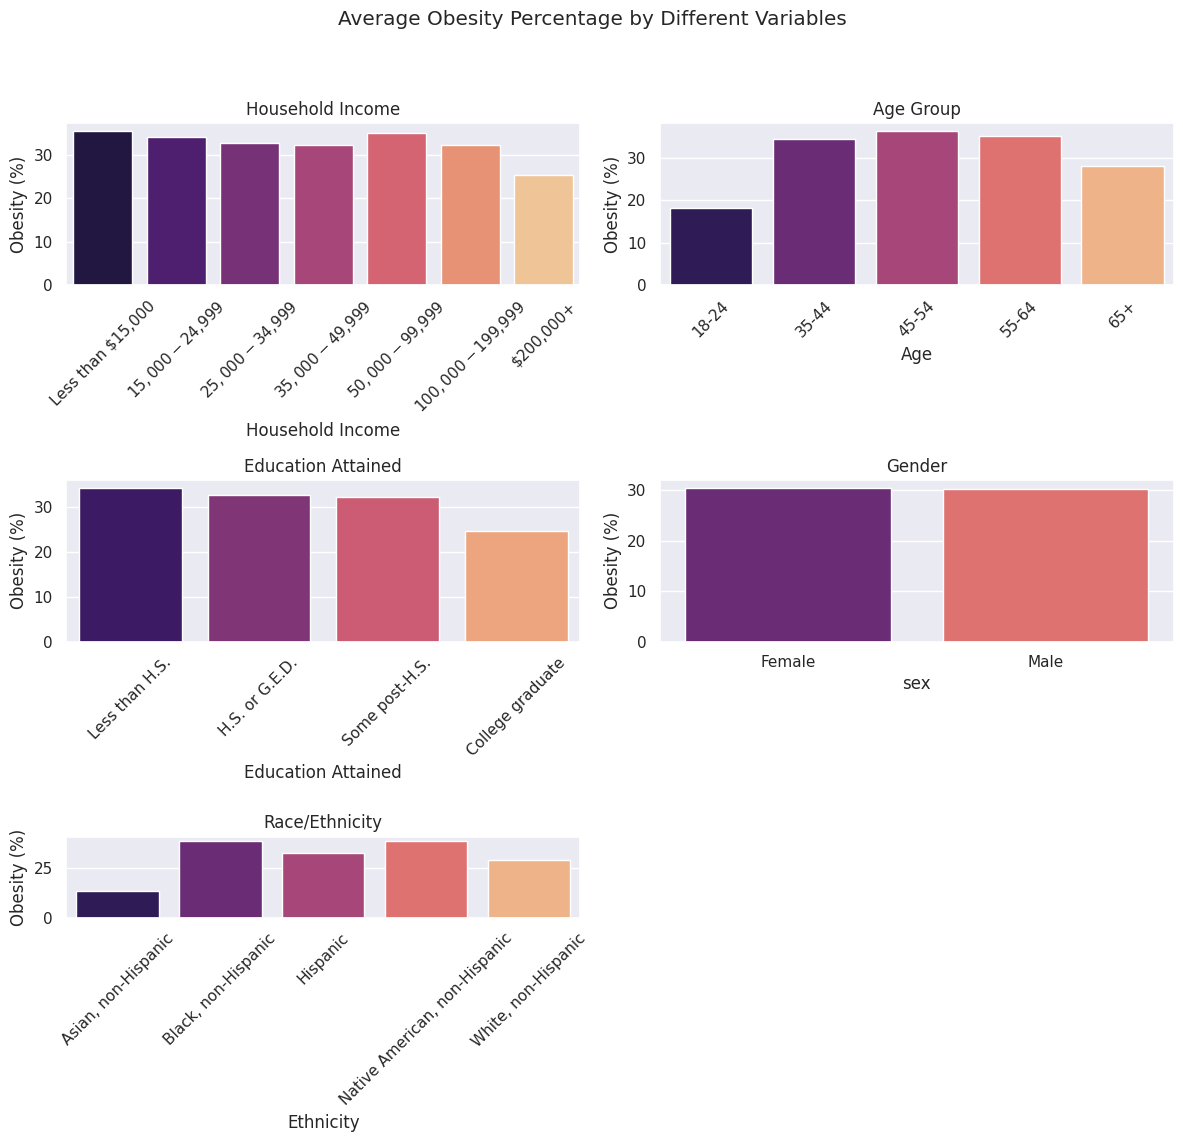

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
df_filtered3 = df[(df['response'] == 'obese (bmi 30.0 - 99.8)') & (df['break_out_category'] != 'Overall')]

columns_of_interest = ['data_value', 'break_out', 'break_out_category']  # Add more columns if needed
df_selected = df_filtered3[columns_of_interest]

# change super long variable name
df_selected['break_out'] = df_selected['break_out'].replace({'American Indian or Alaskan Native, non-Hispanic': 'Native American, non-Hispanic'})
import pandas as pd
df_selected['data_value'] = pd.to_numeric(df_selected['data_value'])
df_income = df_selected[(df_selected['break_out_category'] == 'Household Income')]
df_income['data_value'] = pd.to_numeric(df_income['data_value'])

# Group by 'Household Income' and calculate the mean for each group
income_means = df_income[df_selected['break_out'].isin(['Less than $15,000', '$15,000-$24,999',
                                                           '$25,000-$34,999', '$35,000-$49,999',
                                                           '$50,000-$99,999', '$100,000-$199,999',
                                                           '$200,000+'])].groupby('break_out')['data_value'].mean().reset_index()

income_means.rename(columns={'break_out': 'Household Income'}, inplace=True)

#age
df_age = df_selected[(df_selected['break_out_category'] == 'Age Group')]
age_means = df_age[df_age['break_out'].isin(['18-24', '24-34',
                                                       '35-44', '45-54',
                                                       '55-64', '65+'])].groupby('break_out')['data_value'].mean().reset_index()
age_means.rename(columns={'break_out': 'Age'}, inplace=True)

#Education
df_edu = df_selected[(df_selected['break_out_category'] == 'Education Attained')]
edu_means = df_edu[df_edu['break_out'].isin(['Less than H.S.', 'H.S. or G.E.D.',
                                                       'Some post-H.S.', 'College graduate'])].groupby('break_out')['data_value'].mean().reset_index()


edu_means.rename(columns={'break_out': 'Education Attained'}, inplace=True)

#gender
df_sex = df_selected[(df_selected['break_out_category'] == 'Gender')]
sex_means = df_sex[df_sex['break_out'].isin(['Male', 'Female'])].groupby('break_out')['data_value'].mean().reset_index()


sex_means.rename(columns={'break_out': 'sex'}, inplace=True)

#race
df_race = df_selected[(df_selected['break_out_category'] == 'Race/Ethnicity')]
race_means = df_race[df_race['break_out'].isin(['White, non-Hispanic', 'Black, non-Hispanic',
                                                       'Native American, non-Hispanic', 'Asian, non-Hispanic',
                                                       'Multiracial, non-Hispanic	', 'Hispanic'])].groupby('break_out')['data_value'].mean().reset_index()
race_means.rename(columns={'break_out': 'Ethnicity'}, inplace=True)


sns.set(style="darkgrid")

# Define the desired order
income_order = ['Less than $15,000', '$15,000-$24,999', '$25,000-$34,999', '$35,000-$49,999', '$50,000-$99,999', '$100,000-$199,999', '$200,000+']

income_means['Household Income'] = pd.Categorical(income_means['Household Income'], categories=income_order, ordered=True)


income_means = income_means.sort_values('Household Income')

# Define the desired order
edu_order = ['Less than H.S.', 'H.S. or G.E.D.', 'Some post-H.S.', 'College graduate']


edu_means['Education Attained'] = pd.Categorical(edu_means['Education Attained'], categories=edu_order, ordered=True)

edu_means = edu_means.sort_values('Education Attained')
income_means.rename(columns={'data_value': 'Obesity (%)'}, inplace=True)
age_means.rename(columns={'data_value': 'Obesity (%)'}, inplace=True)
edu_means.rename(columns={'data_value': 'Obesity (%)'}, inplace=True)
sex_means.rename(columns={'data_value': 'Obesity (%)'}, inplace=True)
race_means.rename(columns={'data_value': 'Obesity (%)'}, inplace=True)


fig, axes = plt.subplots(3, 2, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 2, 1]})
fig.suptitle('Average Obesity Percentage by Different Variables')

# income
sns.barplot(ax=axes[0, 0], x='Household Income', y='Obesity (%)', data=income_means, palette='magma')
axes[0, 0].set_title('Household Income')
axes[0, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# age
sns.barplot(ax=axes[0, 1], x='Age', y='Obesity (%)', data=age_means, palette='magma')
axes[0, 1].set_title('Age Group')
axes[0, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# edu
sns.barplot(ax=axes[1, 0], x='Education Attained', y='Obesity (%)', data=edu_means, palette='magma')
axes[1, 0].set_title('Education Attained')
axes[1, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# sex
sns.barplot(ax=axes[1, 1], x='sex', y='Obesity (%)', data=sex_means, palette='magma')
axes[1, 1].set_title('Gender')

# race
sns.barplot(ax=axes[2, 0], x='Ethnicity', y='Obesity (%)', data=race_means, palette='magma')
axes[2, 0].set_title('Race/Ethnicity')
axes[2, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
fig.delaxes(axes[2, 1])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


4) Finally, we should conduct some statistical tests to see how each variable influences overall obesity in each state. First, we will filter for all where response is not in Overall, then merge the dataframe with state averages for obesity together with a pivoted dataframe where all the possible break_out variables are now new columns. The resulting combined dataframe is shown below.

In [ ]:

df_1st = df[(df['response'] == 'obese (bmi 30.0 - 99.8)') & (df['break_out_category'] != 'Overall')]

df_1st = df_1st.rename(columns={'data_value': 'obesity'})
df_1st = df_1st.drop(columns=['sample_size', 'response', 'break_out', 'break_out_category', 'confidence_limit_low', 'confidence_limit_high'])
df_1st['obesity'] = pd.to_numeric(df_1st['obesity'], errors='coerce')

# find the state averages for obesity
state_means = df_1st.groupby(['year', 'locationdesc'])[['obesity']].mean().reset_index()

df_no_overall = df[(df['break_out_category'] != 'Overall') & (df['response'] == 'obese (bmi 30.0 - 99.8)')]

# filter for all break_out besides overall
df_no_overall = df_no_overall.rename(columns={'data_value': 'obesity'})



# Pivot the dataframe, so that each variable in break_out becomes its own column (Was so annoying)

pivot_df = df_no_overall.pivot_table(index=['year', 'locationdesc'],
                             columns='break_out',
                             values='obesity',
                             aggfunc='first').reset_index()

bigmerged_df = pd.merge(pivot_df, state_means, on=['year', 'locationdesc'], how='left')
bigmerged_df['obesity'] = pd.to_numeric(bigmerged_df['obesity'], errors='coerce')
print(bigmerged_df.head(3))

   year locationdesc $100,000-$199,999 $15,000-$24,999 $200,000+  \
0  2011      Alabama               NaN            34.8       NaN   
1  2011       Alaska               NaN            30.2       NaN   
2  2011      Arizona               NaN            32.3       NaN   

  $25,000-$34,999 $35,000-$49,999 $50,000+ $50,000-$99,999 18-24  ...  \
0            35.8            32.3     30.9             NaN  16.3  ...   
1            32.2            24.5     27.2             NaN  19.8  ...   
2            26.5            20.7     21.7             NaN  18.7  ...   

  Hispanic Less than $15,000 Less than H.S.  Male Multiracial, non-Hispanic  \
0     28.6              38.5           33.6  32.3                       NaN   
1     31.5              33.6           28.8  28.0                      23.3   
2     33.8              34.1           36.2  24.4                       NaN   

  Native Hawaiian or other Pacific Islander, non-Hispanic Other, non-Hispanic  \
0                                   

First, lets focus is on exploring the relationship between income levels, and its potential impact on obesity. I want to look at how making 'Less than $15,000' can predict obesity levels. The earlier observations from the graphs suggest that individuals with an income less than 15,000 dollars exhibit the highest obesity percentage. However, the disparity in obesity rates among different income ranges is not significantly pronounced at all. Let us see what the linear model produces.


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# drop NaNs
bigmerged_df = bigmerged_df.dropna(subset=['Less than $15,000'])
bigmerged_df = bigmerged_df.dropna(subset=['obesity'])
# columns to test
X = bigmerged_df['Less than $15,000'].values.reshape(-1, 1)  # Independent variable
y = bigmerged_df['obesity'].values  # Dependent variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean Squared Error:', mse)
print('R-squared:', r2)


Coefficients: [0.57371474]
Intercept: 10.898324406405212
Mean Squared Error: 6.503408305767623
R-squared: 0.555624064005134


The result is indeed as expected. The positive coefficient for 'Less than $15,000' implies that there is a positive linear relationship between lower income levels and obesity. However, it's essential to note that the coefficient is modest, suggesting that while there is a discernible trend, income alone may not be the sole determinant of obesity.

The $R^2$ of 0.537 indicates that the model explains a considerable portion of the variability in obesity based on income. But there are many other variables in play, such as education or age, that could also impact obesity. Lets then consider those as well, in the next model. We will use being '45-54' and having 'Less than H.S' education together with 'Less than $15,000' as independent variables with obesity as the dependent.

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# drop NaNs
bigmerged_df = bigmerged_df.dropna(subset=['45-54', 'Less than H.S.', 'Less than $15,000', 'obesity'])

# columns to test
X = bigmerged_df[['45-54', 'Less than H.S.','Less than $15,000']]  # Independent variables
y = bigmerged_df['obesity']  # Dependent variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean Squared Error:', mse)
print('R-squared:', r2)


Coefficients: [0.55224742 0.08335827 0.12840453]
Intercept: 3.7665510547402334
Mean Squared Error: 1.682708331734083
R-squared: 0.8850210451560396


The collective impact of these variables is reflected in the high $R^2$ value of 0.868, suggesting that the model effectively captures the majority of the variability in obesity based on the selected features. The inclusion of multiple variables enhances the model's ability to explain and predict obesity more accurately than considering 'Less than $15,000' alone.

As a bonus, lets use a different model, the Random Forest Regressor, to look at how being 'Black, non-Hispanic' could be a predictor for obesity.

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# drop NaNs
bigmerged_df = bigmerged_df.dropna(subset=['Black, non-Hispanic'])
bigmerged_df = bigmerged_df.dropna(subset=['obesity'])

# columns to test
X = bigmerged_df['Black, non-Hispanic'].values.reshape(-1, 1)  # Independent variable
y = bigmerged_df['obesity'].values  # Dependent variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)


Mean Squared Error: 10.972947927732784
R-squared: 0.3667613080274579


A $R^2$ value of 0.367 implies that the variable 'Black, non-Hispanic' alone explains a somewhat moderate proportion of the variability in obesity within the dataset. This is perfectly in line, I believe, with what we could get from the graphs. While African Americans do have a high percentage of obesity in America, so do Hispanics and those with Native Americans roots, making it not as obvious to predictive models.



---



# Section II: BRFSS Table of Physical Activity

Next, we will analyze the BRFSS' Table for Physical Activity, a dataset akin to the previous one on Overweight and Obesity (BMI). Similar to BMI, this dataset comprises prevalence data collected through both landline and phone calls as part of the Behavioral Risk Factors Surveillance System.

While the columns remain consistent with the previous dataset, a notable distinction exists. In the prior dataset, respondents were queried solely about their BMI. In contrast, the Table for Physical Activity delves into a broader spectrum. Respondents were posed with four distinct yes-or-no questions, each on varying levels of physical activity. To account for this multiplicity, an additional column, labeled **Topic**, has been introduced to distinguish between these four questions. The questions encompass various facets of physical activity, offering a more nuanced perspective on respondents' behaviors. The four questions are:

"During the past month,

1.  **Exercise:** ...did you participate in any physical activities?" _With 29742 rows._

2.  **Aerobic Activity:** ...did you participate in 150 minutes or more of Aerobic Physical Activity per week?" _With 12146 rows._

3. **Strength Activity:** ...did you participate in muscle strengthening exercises two or more times per week?" _With 12071 rows._

4. **Physical Activity Index:** ...did you participate in enough Aerobic and Muscle Strengthening exercises to meet guidelines?" _With 11896 rows._

The last 3 questions have less than half the rows of the first, as these were only asked to interviewees in 2013, 2015, 2017, and 2019.

In [ ]:


# CDC API endpoint
api_url = "https://data.cdc.gov/resource/urh8-82n7.json"


columns_to_keep = ['year', 'locationdesc', 'sample_size', 'topic', 'response', 'break_out', 'break_out_category', 'data_value', 'confidence_limit_low', 'confidence_limit_high']  # Replace with your actual column names


dfs = []


batch_size = 1000

# Make requests until all data is retrieved
offset = 0
while True:
    params = {'$offset': offset, '$limit': batch_size}
    response = requests.get(api_url, params=params)

    if not response.json():
        break

    dfs.append(pd.DataFrame(response.json(), columns=columns_to_keep))
    offset += batch_size

df2 = pd.concat(dfs, ignore_index=True)

# Drop rows with null values in 'data_value'
df2 = df2.dropna(subset=['data_value'])


df2['topic'] = df2['topic'].str.replace('.', '')
df2 = df2[~df2['locationdesc'].str.contains('median')]
print("Dimensions of the DataFrame: ", df2.shape)


In [ ]:

print(df2.head(3))

   year locationdesc sample_size     topic response break_out  \
0  2022      Alabama        3110  Exercise      Yes   Overall   
1  2022      Alabama        1389  Exercise       No   Overall   
2  2022      Alabama        1372  Exercise      Yes      Male   

  break_out_category data_value confidence_limit_low confidence_limit_high  
0            Overall       71.0                 69.2                  72.8  
1            Overall       29.0                 27.2                  30.8  
2             Gender       76.6                 74.2                  79.1  


1) Our first interest is to find out the relationship between those that answered "No" to the most basic question. Did they participate in ANY physical activity in the past month? By filtering the Obesity dataset and the Exercise dataset under their respective parameters, and then combining them into one singular dataframe, we can chart the trends over the years relating lack of exercise to obesity rate.

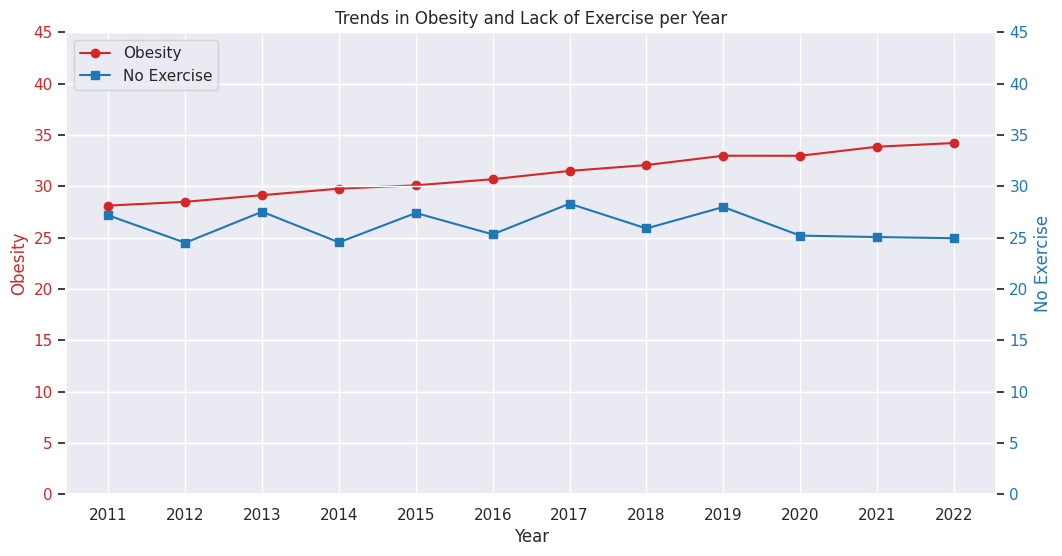

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
# Filter df2
df2_filtered = df2[(df2['topic'] == 'Exercise') & (df2['response'] == 'No')]


# Rename
df2_filtered = df2_filtered.rename(columns={'data_value': 'no_exercise'})

df2_filtered = df2_filtered.drop(columns=['sample_size', 'topic', 'response', 'break_out', 'break_out_category', 'confidence_limit_low', 'confidence_limit_high'])

# Merge the two datasets based on common columns
combined_df = pd.merge(df_1st, df2_filtered, on=['year', 'locationdesc'], how='outer')


combined_df['obesity'] = pd.to_numeric(combined_df['obesity'], errors='coerce')
combined_df['no_exercise'] = pd.to_numeric(combined_df['no_exercise'], errors='coerce')
combined_df = combined_df.dropna(subset=['no_exercise'])

country_means = combined_df.groupby('year')[['obesity', 'no_exercise']].mean().reset_index()


threshold = range(0, 50, 5)

fig, ax1 = plt.subplots(figsize=(12, 6))

#plot obesity
ax1.plot(country_means['year'], country_means['obesity'], color='tab:red', marker='o', label='Obesity')
ax1.set_xlabel('Year')
ax1.set_ylabel('Obesity', color='tab:red')
ax1.set_yticks(threshold)
ax1.set_ylim(0, 45)
ax1.tick_params(axis='y', labelcolor='tab:red')
#plot exercise
ax2 = ax1.twinx()
ax2.plot(country_means['year'], country_means['no_exercise'], color='tab:blue', marker='s', label='No Exercise')
ax2.set_ylabel('No Exercise', color='tab:blue')
ax2.set_yticks(threshold)
ax2.set_ylim(0, 45)
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Trends in Obesity and Lack of Exercise per Year')
plt.show()

These results were surprising, primarily because it would seem that people claiming to not have exercised the past month was not increasing at all, while obesity ultimately has been.

In [ ]:

correlation = country_means['no_exercise'].corr(country_means['obesity'])

print(f"Pearson Correlation Coefficient: {correlation}")

Pearson Correlation Coefficient: -0.13961434204494097


As one can see from the Pearson Correlation Coefficient, there is a slight but still negative linear relationship between people reporting no exercise and obesity rate.

There are many possibilities as to why that could be. For starters, people may be too embarassed to report that they have not done a single physical activity in the last month. Afterall, unlike the other questions, "have you done any physical activity in the last month" has no specification as to what counts as a physical activity. Furthermore, there is always more variables to managing weight than physical activity, such as diet or occupation.

2) We should take a visit then to the most obese state, which we found was West Virgina earlier in the project, to confirm that this negative relationship is found here as well.

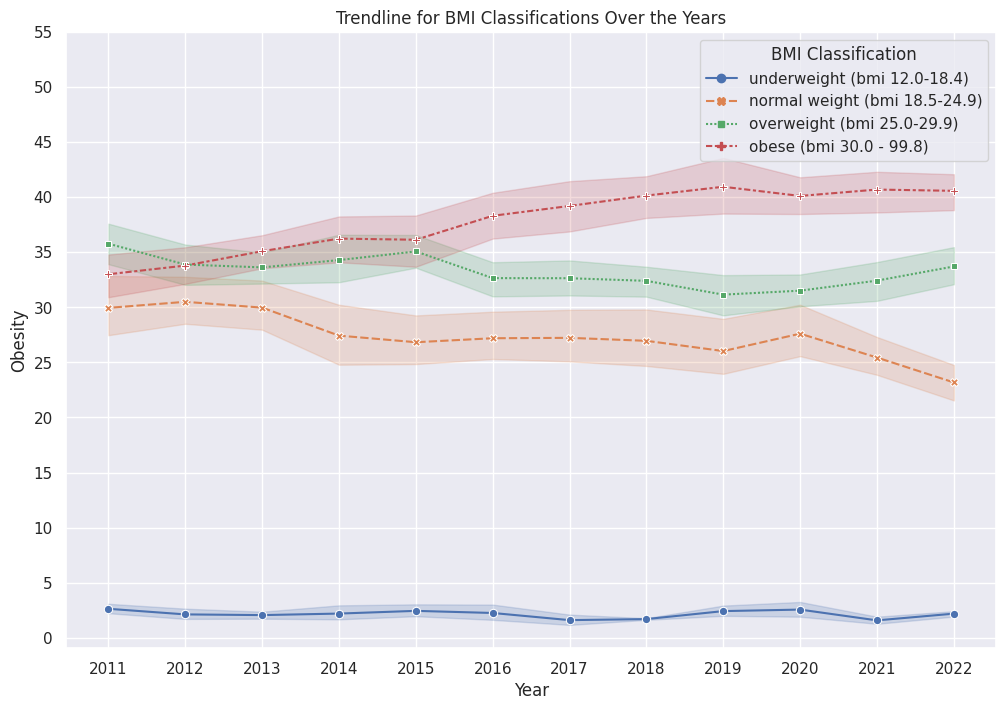

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
wv_data = df[df['locationdesc'] == 'West Virginia']
wv_data['data_value'] = pd.to_numeric(wv_data['data_value'], errors='coerce')

sns.set(style="darkgrid")

plt.figure(figsize=(12, 8))
sns.lineplot(data=wv_data, x="year", y="data_value", hue="response", style="response", markers=True)


plt.legend(title="BMI Classification")

plt.title("Trendline for BMI Classifications Over the Years")
plt.xlabel("Year")
plt.ylabel("Obesity")

plt.yticks(range(0, int(wv_data['data_value'].max()) + 5, 5))


plt.xlim(reversed(plt.xlim()))


plt.show()


As expected, the proportion of those classifying as obese is quite high.

In [ ]:


# filter
df2_filtered = df2[(df2['topic'] == 'Exercise') & (df2['response'] == 'No')]


df2_filtered = df2_filtered.rename(columns={'data_value': 'no_exercise'})

df2_filtered = df2_filtered.drop(columns=['sample_size', 'topic', 'response', 'break_out', 'break_out_category', 'confidence_limit_low', 'confidence_limit_high'])

# Merge
combined_df = pd.merge(df_1st, df2_filtered, on=['year', 'locationdesc'], how='outer')

combined_df['obesity'] = pd.to_numeric(combined_df['obesity'], errors='coerce')
combined_df['no_exercise'] = pd.to_numeric(combined_df['no_exercise'], errors='coerce')
combined_df = combined_df.dropna(subset=['no_exercise'])


#  calculate mean for 'obesity' and 'exercise'
country_means = combined_df.groupby('year')[['obesity', 'no_exercise']].mean().reset_index()

state_means2 = combined_df.groupby(['year', 'locationdesc'])[['obesity', 'no_exercise']].mean().reset_index()
state_wv = state_means2[state_means2['locationdesc'] == 'West Virginia']


finalmerged_df = pd.merge(pivot_df, state_means2, on=['year', 'locationdesc'], how='left')

print(state_wv)

     year   locationdesc    obesity  no_exercise
50   2011  West Virginia  33.042857    34.077273
103  2012  West Virginia  33.800000    30.408696
156  2013  West Virginia  35.104762    30.754545
209  2014  West Virginia  36.280000    29.126087
262  2015  West Virginia  36.175000    30.533333
316  2016  West Virginia  38.355000    28.480952
369  2017  West Virginia  39.275000    31.319048
422  2018  West Virginia  40.216667    27.847619
474  2019  West Virginia  41.025000    30.623810
527  2020  West Virginia  40.188235    29.547619
580  2021  West Virginia  40.713043    29.383333
634  2022  West Virginia  40.573913    29.504167


In [ ]:

correlation = state_wv['no_exercise'].corr(state_wv['obesity'])

print(f"Pearson Correlation Coefficient: {correlation}")

Pearson Correlation Coefficient: -0.5583356130088737



The Pearson Correlation Coefficient for West Virginia reveals a notably more pronounced negative correlation between reported lack of exercise and obesity. I am further convinced with my initial hypothesis, that the ambiguous nature of the 'have you done any physical activity?' question may contribute to increased volatility in the results.

If we switch to the next question regarding Aerobic Activity, there is a significantly more specific inquiry about whether 150 minutes of aerobic activity has been performed. The specificity of this question may lead to more precise responses and, consequently, less volatility in the data.

In [ ]:


df2_filtered2 = df2[(df2['topic'] == 'Aerobic Activity') & (df2['response'] == 'No')]
# rename for clarity
df2_filtered2 = df2_filtered2.rename(columns={'data_value': 'no_exercise'})

df2_filtered2 = df2_filtered2.drop(columns=['sample_size', 'topic', 'response', 'break_out', 'break_out_category', 'confidence_limit_low', 'confidence_limit_high'])
# MERGE
combined_df2 = pd.merge(df_1st, df2_filtered2, on=['year', 'locationdesc'], how='outer')


combined_df2['obesity'] = pd.to_numeric(combined_df2['obesity'], errors='coerce')
combined_df2['no_exercise'] = pd.to_numeric(combined_df2['no_exercise'], errors='coerce')
combined_df2 = combined_df2.dropna(subset=['no_exercise'])

country_means2 = combined_df2.groupby('year')[['obesity', 'no_exercise']].mean().reset_index()
print(country_means2)

   year    obesity  no_exercise
0  2011  28.145558    50.033847
1  2013  29.147627    50.568113
2  2015  30.117182    49.828459
3  2017  31.573982    51.331642
4  2019  33.032886    51.112443


In [ ]:

state_means3 = combined_df2.groupby(['year', 'locationdesc'])[['obesity', 'no_exercise']].mean().reset_index()
state_wv2 = state_means3[state_means3['locationdesc'] == 'West Virginia']

print(state_wv2)

     year   locationdesc    obesity  no_exercise
50   2011  West Virginia  33.042857    55.952174
103  2013  West Virginia  35.104762    52.268182
156  2015  West Virginia  36.175000    51.947619
209  2017  West Virginia  39.275000    52.119048
261  2019  West Virginia  41.025000    52.333333


In [ ]:

correlation = country_means2['no_exercise'].corr(country_means2['obesity'])
correlation2 = state_wv2['no_exercise'].corr(state_wv2['obesity'])

print(f"Pearson Correlation Coefficient (National): {correlation}")
print(f"Pearson Correlation Coefficient (West Virgina): {correlation2}")

Pearson Correlation Coefficient (National): 0.7782250316208482
Pearson Correlation Coefficient (West Virgina): -0.6507981115636158


On a national level, excluding 150 minutes of aerobic activity per month has a strong correlation with rising obesity levels. The same, however, cannot be said for West Virgina. It would seem that West Virginia is either full of liars, or exercise as a whole is simply not a very good predictor for obesity in this state. Therefore, we will next look at cholesterol awareness to see if diet or diet related health awareness can prove a stronger correlation to obesity in a state.


---



# Section III: BRFSS Table of Cholesterol Awareness

For the third and final dataset, we will analyze the BRFSS' Table for Cholesterol Awareness. Like the others, this dataset was also collected through both landline and phone calls.

Unlike the others, information for Cholesterol Awareness has only been collected on odd numbered years. That will have to be kept in mind when analyzing the data or making any claims.

Respondents were posed with two questions. One is a multiple choice, where interviewees were asked if they had their cholesterol checked within the last five years. The possible answers were 'Checked in past 5 years', 'Not Checked in past 5 years', or 'Never Checked'. It has the **Topic** classification 'Cholesterol Checked'. The second question is a pure yes-or-no question, asking if out of the respondents had their cholesterol checked they got a report back claiming that it is high. It's **Topic** is 'Cholesterol High'.

In [ ]:
# @title


# CDC API endpoint
api_url = "https://data.cdc.gov/resource/xar7-74yx.json"


columns_to_keep = ['year', 'locationdesc', 'sample_size', 'topic', 'response', 'break_out', 'break_out_category', 'data_value', 'confidence_limit_low', 'confidence_limit_high']  # Replace with your actual column names


dfs = []


batch_size = 1000

# Make requests until all data is retrieved
offset = 0
while True:
    params = {'$offset': offset, '$limit': batch_size}
    response = requests.get(api_url, params=params)

    if not response.json():
        break

    dfs.append(pd.DataFrame(response.json(), columns=columns_to_keep))
    offset += batch_size

df3 = pd.concat(dfs, ignore_index=True)

# Drop rows with null values in 'data_value'
df3 = df3.dropna(subset=['data_value'])

# Lowercase 'response' column
df3['response'] = df3['response'].str.lower()

df3['topic'] = df3['topic'].str.replace('.', '')
df3 = df3[~df3['locationdesc'].str.contains('median')]
print("Dimensions of the DataFrame: ", df3.shape)



In [ ]:
# @title

print(df3.tail(3))

       year locationdesc sample_size                topic  \
47837  2011  Connecticut        2839  Cholesterol Checked   
47838  2011  Connecticut          95  Cholesterol Checked   
47839  2011  Connecticut         199  Cholesterol Checked   

                          response break_out break_out_category data_value  \
47837      checked in past 5 years  $50,000+   Household Income       85.7   
47838  not checked in past 5 years  $50,000+   Household Income        3.4   
47839                never checked  $50,000+   Household Income       10.8   

      confidence_limit_low confidence_limit_high  
47837                 83.7                  87.8  
47838                  2.5                   4.3  
47839                  8.9                  12.7  


1) First, let's look at chloropleth maps and compare states with high cholesterol and states with high obesity for 2021.

In [ ]:
# @title

import geopandas as gpd
import folium
from IPython.display import HTML, display
high_c = df3[(df3['response'] == 'yes') &
                  (df3['topic'] == 'Cholesterol High') &
                  (df3['break_out_category'] == 'Overall') &
                  (df3['year'] == '2021')]

high_o = df[(df['break_out_category'] == 'Overall')
                 & (df['year'] == '2021')
                 & (df['response'] == 'obese (bmi 30.0 - 99.8)')]


merged_data3 = us_states.merge(high_c, left_on='name', right_on='locationdesc')

merged_data3['data_value'] = pd.to_numeric(merged_data3['data_value'], errors='coerce')

merged_data3 = merged_data3.dropna(subset=['data_value'])
threshold_scale = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

m3 = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='cartodb positron')

# chloropleth with folium
choropleth3 = folium.Choropleth(
    geo_data=merged_data3,
    name='Your Choropleth Map',
    data=merged_data3,
    columns=['name', 'data_value'],
    key_on='feature.properties.name',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='High Cholesterol (%)',
    threshold_scale=threshold_scale
).add_to(m3)

tooltip3 = folium.features.GeoJsonTooltip(fields=['name', 'data_value'], aliases=['State: ', 'Percent of Population with High Cholesterol: '])
choropleth3.geojson.add_child(tooltip3)

merged_data4 = us_states.merge(high_o, left_on='name', right_on='locationdesc')

merged_data4['data_value'] = pd.to_numeric(merged_data4['data_value'], errors='coerce')

merged_data4 = merged_data4.dropna(subset=['data_value'])

m4 = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='cartodb positron')

choropleth4 = folium.Choropleth(
    geo_data=merged_data4,
    name='Your Choropleth Map',
    data=merged_data4,
    columns=['name', 'data_value'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Obesity (%)',
    threshold_scale=threshold_scale
).add_to(m4)

# Add tooltips on mouse hover
tooltip4 = folium.features.GeoJsonTooltip(fields=['name', 'data_value'], aliases=['State: ', 'Percent of Population Obese: '])
choropleth4.geojson.add_child(tooltip4)

# Place both maps side by side using html
html = HTML(f"""
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 48%; margin-right: 2%;">{m3._repr_html_()}</div>
        <div style="width: 48%;">{m4._repr_html_()}</div>
    </div>
""")

display(html)


*Note: BRFSS did not report data for Florida in 2021.*

As expected, there is a fairly strong correlation between high cholesterol and high obesity, at least at an initial look.

2) Next, lets look at how cholesterol rates have transformed over the years.

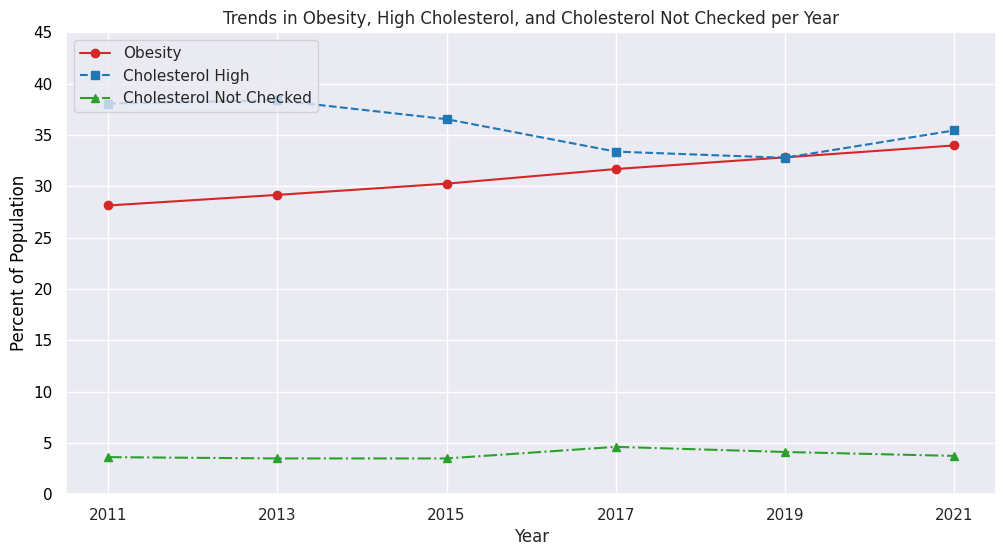

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
high_df = df3[(df3['topic'] == 'Cholesterol High') &
               (df3['response'] == 'yes')
                & (df3['break_out_category'] == 'Overall')]

check_df = df3[(df3['topic'] == 'Cholesterol Checked') &
               (df3['response'] == 'not checked in past 5 years')
                & (df3['break_out_category'] == 'Overall')]

high_df['data_value'] = pd.to_numeric(high_df['data_value'], errors='coerce')
high_df = high_df.rename(columns={'data_value': 'c_high'})

check_df['data_value'] = pd.to_numeric(check_df['data_value'], errors='coerce')
check_df = check_df.rename(columns={'data_value': 'c_not_checked'})

high_df = high_df[['year', 'locationdesc', 'c_high']]

check_df = check_df[['year', 'locationdesc', 'c_not_checked']]

merged_df = pd.merge(high_df, check_df, on=['locationdesc', 'year'], how='inner')

# Merging
co_df = pd.merge(merged_df, state_means, on=['locationdesc', 'year'], how='inner')

country_means2 = co_df.groupby('year')[['obesity', 'c_high', 'c_not_checked']].mean().reset_index()
threshold = range(0, 50, 5)

# Create a figure with a larger width
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(country_means2['year'], country_means2['obesity'], color='tab:red', marker='o', label='Obesity')
ax1.plot(country_means2['year'], country_means2['c_high'], color='tab:blue', marker='s', linestyle='--', label='Cholesterol High')
ax1.plot(country_means2['year'], country_means2['c_not_checked'], color='tab:green', marker='^', linestyle='-.', label='Cholesterol Not Checked')

ax1.set_xlabel('Year')
ax1.set_ylabel('Percent of Population', color='black')  # Use black for the y-axis label
ax1.set_yticks(threshold)
ax1.set_ylim(0, 45)
ax1.tick_params(axis='y', labelcolor='black')  # Use black for the y-axis ticks

ax1.legend(loc='upper left')

plt.title('Trends in Obesity, High Cholesterol, and Cholesterol Not Checked per Year')
plt.show()


Surprisingly, cholesterol rates have in fact dropped significantly over time! So while the previous chloropleth maps indeed suggest high chloresterol is tied to increased obesity, it does not paint the full picture. We can use the bokeh library to make a graph with a slider to make an even more poignant visualization of this trend.

In [ ]:

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Slider
from bokeh.layouts import layout
from bokeh.io import output_notebook
from bokeh.models import CustomJS
import pandas as pd

co_df['year'] = co_df['year'].astype(int)

co_df = co_df[co_df['year'] % 2 != 0]

output_notebook()
source = ColumnDataSource(co_df)


p = figure(title="Obesity vs High Cholesterol",
           x_axis_label="High Cholesterol (%)",
           y_axis_label="Obesity (%)")


scatter = p.scatter(x='c_high', y='obesity', size=10, color="blue", source=source)


hover = HoverTool()
hover.tooltips = [("Location", "@locationdesc"), ("Year", "@year")]
p.add_tools(hover)


slider = Slider(start=co_df['year'].min(), end=co_df['year'].max(), value=co_df['year'].min(), step=2, title="Year")
# javascript
callback = CustomJS(args=dict(source=source, slider=slider), code="""
    var data = source.data;
    var year = slider.value;
    var indices = [];
    for (var i = 0; i < data['year'].length; i++) {
        if (data['year'][i] == year) {
            indices.push(i);
        }
    }
    source.selected.indices = indices;
    source.change.emit();
""")

slider.js_on_change('value', callback)

layout = layout([[p], [slider]])
show(layout)


3) In the previous part, the percentage of the population who did not report having their cholesterol 'not checked in the past five years' was also plotted. By analyzing the correlation matrix between the variables, we can see how these health indicators relate to each other. The correlation coefficient provides insights into the strength and direction of the linear relationship between two variables on obesity, just as we did in the previous part with Pearson's Correlation and exercise.

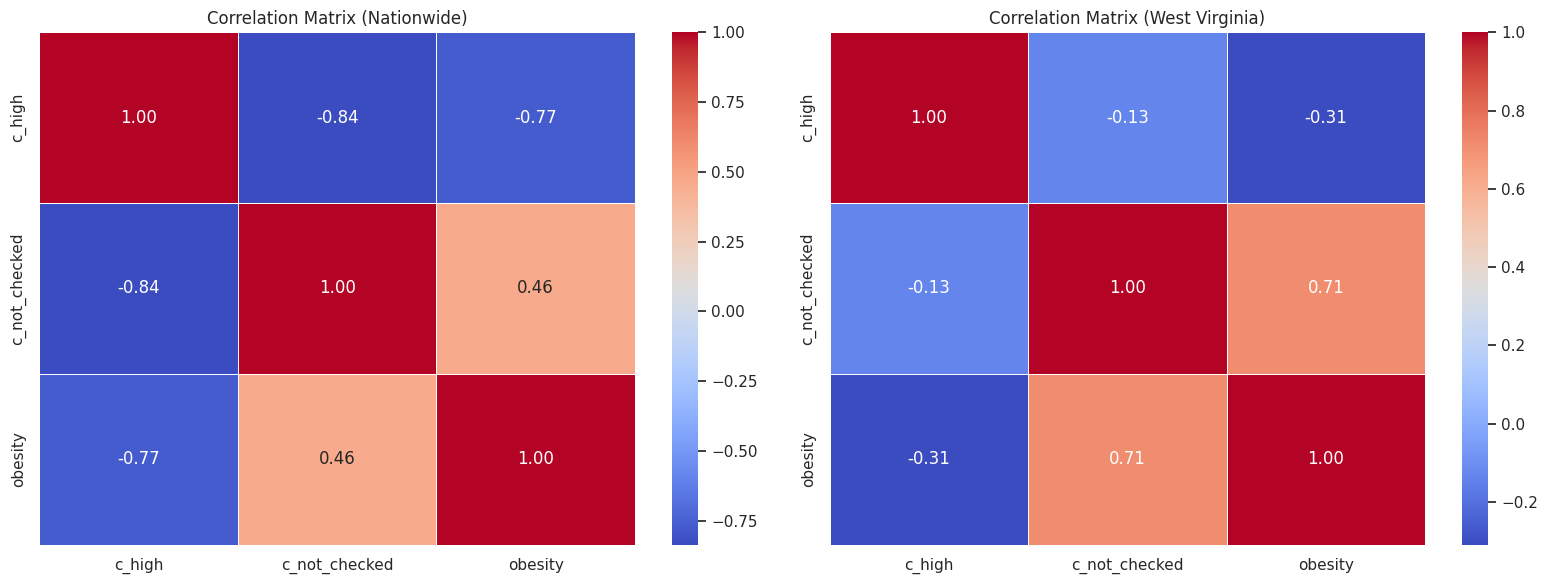

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

final_wv = co_df[co_df['locationdesc'] == 'West Virginia']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Nationwide Correlation Matrix
correlation_matrix_nationwide = country_means2[['c_high', 'c_not_checked', 'obesity']].corr()
sns.heatmap(correlation_matrix_nationwide, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axes[0])
axes[0].set_title('Correlation Matrix (Nationwide)')

# West Virginia Correlation Matrix
correlation_matrix_wv = final_wv[['c_high', 'c_not_checked', 'obesity']].corr()
sns.heatmap(correlation_matrix_wv, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axes[1])
axes[1].set_title('Correlation Matrix (West Virginia)')

plt.tight_layout()
plt.show()


Finally, we have a convincing argument of a variable that has strong linear relationship with obesity, being having your cholesterol not checked in the last five years. Especially in an obese state like West Virginia.

# 6. Summary

I believe this project offered solid insight into obesity and related variables in the United States. We began by analyzing BMI classifications and how they have transformed over the years, and how different groups can have varying obesity trends. We then looked into the correlation with exercise rates with obesity, and found that the data provided by the BRFSS at least did not suggest a very convincing relationship between simple exercise and obesity. Due to the nature of the questions asked in the exercise dataset, and how low the necessary threshold was to qualify as someone who did a physical activity, there was a need to analyze a third dataset. High cholesterol had a promising start when looking at the chloropleth graphs for one year, but upon further analysis it turned out that high cholesterol reports were not a great predictor for obesity. However, not having cholesterol checked within the past five years did have a strong linear pattern. I believe the possible reason for this is that getting your cholesterol checked has other health issues checked at the same time by the doctor, and it also shows a certain level of commitment to monitoring your health compared to those who never got cholesterol checked.

Ultimately, this project proved to be a fun and interesting experiment on the datasets. I was able to learn significantly more about pandas, numpy, matplotlib, and seaborn's capacities.